In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import re
import string
import pickle
import random
import tarfile
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Embedding, LSTM, TimeDistributed, Input, SimpleRNN, Bidirectional, Dense, RepeatVector, Concatenate, Attention, Dot, Activation
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
training_dir = '/content/drive/MyDrive/capstone/'

# Load the datasets into pandas DataFrames
europarl_de = os.path.join(training_dir, 'europarl-v7.de-en.de')
europarl_en = os.path.join(training_dir, 'europarl-v7.de-en.en')
commoncrawl_de = os.path.join(training_dir, 'commoncrawl.de-en.de')
commoncrawl_en = os.path.join(training_dir, 'commoncrawl.de-en.en')

In [7]:
def load_dataset(de_path, en_path):
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

    # Check if lengths match
    if len(de_sentences) != len(en_sentences):
        print(f"Length mismatch: {de_path} ({len(de_sentences)}) and {en_path} ({len(en_sentences)})")
        # Truncate to the shorter length
        min_length = min(len(de_sentences), len(en_sentences))
        de_sentences = de_sentences[:min_length]
        en_sentences = en_sentences[:min_length]

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

# Load datasets
europarl = load_dataset(europarl_de, europarl_en)
commoncrawl = load_dataset(commoncrawl_de, commoncrawl_en)

In [8]:
#Print the shape of each dataset
print("Shape of Europarl German dataset :",europarl.shape)

Shape of Europarl German dataset : (1920209, 2)


In [9]:
print("Shape of CommonCarl German dataset :",commoncrawl.shape)

Shape of CommonCarl German dataset : (2399123, 2)


In [10]:
# Merge the datasets
df = pd.concat([europarl, commoncrawl], ignore_index=True)

# Display the number of sentences
print(f"Total number of sentences in the dataset: {len(df)}")

Total number of sentences in the dataset: 4319332


In [11]:
# Display entire dataframe
pd.set_option('display.max_colwidth', None)  # Display full contents of each column without truncation
pd.set_option('display.max_rows', None)      # Display all rows

In [12]:
df.head(50)

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"
5,"Ich bitte Sie, sich zu einer Schweigeminute zu erheben.\n","Please rise, then, for this minute' s silence.\n"
6,(Das Parlament erhebt sich zu einer Schweigeminute.)\n,(The House rose and observed a minute' s silence)\n
7,"Frau Präsidentin, zur Geschäftsordnung.\n","Madam President, on a point of order.\n"
8,"Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.\n",You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.\n
9,"Zu den Attentatsopfern, die es in jüngster Zeit in Sri Lanka zu beklagen gab, zählt auch Herr Kumar Ponnambalam, der dem Europäischen Parlament erst vor wenigen Monaten einen Besuch abgestattet hatte.\n","One of the people assassinated very recently in Sri Lanka was Mr Kumar Ponnambalam, who had visited the European Parliament just a few months ago.\n"


In [13]:
# Taking 5000 from each dataset to proceed with machine translation
europarl = europarl.sample(n=5000, random_state=42)
commoncrawl = commoncrawl.sample(n=5000, random_state=42)
# Merge the datasets
merged_df = pd.concat([europarl, commoncrawl], ignore_index=True)

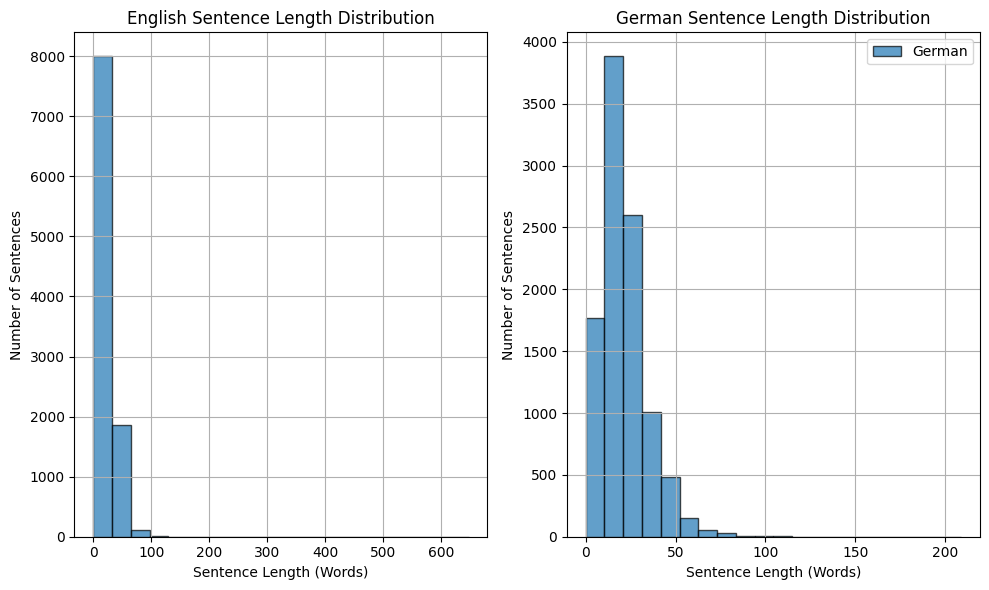

In [14]:
english_sentences = merged_df["English"].tolist()
german_sentences = merged_df["German"].tolist()

# Calculate sentence lengths
english_lengths = [len(sentence.split()) for sentence in english_sentences]
german_lengths = [len(sentence.split()) for sentence in german_sentences]

# Create a histogram plot with two subplots
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.subplot(1, 2, 1)  # First subplot for English lengths
plt.hist(english_lengths, bins=20, edgecolor='black', alpha=0.7, label='English')
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Number of Sentences")
plt.title("English Sentence Length Distribution")
plt.grid(True)

plt.subplot(1, 2, 2)  # Second subplot for German lengths
plt.hist(german_lengths, bins=20, edgecolor='black', alpha=0.7, label='German')
plt.xlabel("Sentence Length (Words)")
plt.ylabel("Number of Sentences")
plt.title("German Sentence Length Distribution")
plt.grid(True)

# Add a legend to the overall figure
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
def cleanse_dataset(dataset):
    # Remove empty lines
    dataset = dataset[(dataset['German'].str.strip() != '') & (dataset['English'].str.strip() != '')]

    # Trim whitespace using .loc to avoid SettingWithCopyWarning
    dataset.loc[:, 'German'] = dataset['German'].str.strip()
    dataset.loc[:, 'English'] = dataset['English'].str.strip()

    # Remove duplicates
    dataset = dataset.drop_duplicates()

    # Remove non-textual characters (e.g., special characters)
    dataset.loc[:, 'German'] = dataset['German'].str.replace(r'[^a-zA-ZäöüßÄÖÜéèêàâçÇ\s]', '', regex=True)
    dataset.loc[:, 'English'] = dataset['English'].str.replace(r'[^a-zA-Z\s]', '', regex=True)

    # Normalize case
    dataset.loc[:, 'German'] = dataset['German'].str.lower()
    dataset.loc[:, 'English'] = dataset['English'].str.lower()

    return dataset

In [16]:
cleanse_df = cleanse_dataset(merged_df)
cleanse_df.shape

(9956, 2)

In [17]:
# Function to remove punctuation from a sentence
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [18]:
# Remove punctuation from both German and English sentences
cleanse_df['German'] = cleanse_df['German'].apply(remove_punctuation)
cleanse_df['English'] = cleanse_df['English'].apply(remove_punctuation)

In [19]:
cleanse_df.head()

,German,English
0,falls es legal ist dann brauchen wir keine debatte zur führen,if it is legal we do not need a debate
1,weitere makrofinanzhilfe für georgien,further macrofinancial assistance for georgia
2,diese forderung verlief im sande zum einen weil das abkommen im juli ausläuft und zum anderen weil wir der ansicht waren dass ein so sensibles thema wie die dauer der vorratsspeicherung erforderlichenfalls gegenstand späterer verhandlungen sein könnte,the request came to nothing firstly because the agreement will come to an end in july and secondly because we have taken the view that a subject as sensitive as the period of data retention could if necessary be a topic for later negotiations
3,so funktioniert der rechtsstaat und lord bethell kann sicher sein dass das dänische rechtswesen entsprechend den prinzipien funktioniert die wir in dieser union hochhalten,that is how the judicial system works and lord bethell can be certain that the danish legal system functions in accordance with all the principles that we uphold in this union
4,wir sind daher durch die weigerung des rates die grundrechtecharta rechtsverbindlich zu machen in eine absurde situation geraten einerseits werden die grundrechte als zwingende konsequenz der anerkennung der würde des menschen betrachtet aber andererseits wird es den menschen verweigert sie tatsächlich als ihr recht geltend machen zu können,the councils refusal to make the charter of fundamental rights binding in law therefore puts us in an absurd situation in which on the one hand fundamental rights are regarded as an inevitable consequence of the recognition of human dignity whilst on the other hand people are denied the chance to exercise their rights


In [20]:
# Load the processed dataset
preprocessed_df = cleanse_df

# Split the data into training and testing sets
train_df, test_df = train_test_split(preprocessed_df, test_size=0.2, random_state=42)

# Separate the German and English columns for both training and testing sets
train_german = train_df['German']
train_english = train_df['English']
test_german = test_df['German']
test_english = test_df['English']

# Tokenization
tokenizer_german = Tokenizer()
tokenizer_english = Tokenizer()

tokenizer_german.fit_on_texts(train_german)
tokenizer_english.fit_on_texts(train_english)

train_german_sequences = tokenizer_german.texts_to_sequences(train_german)
train_english_sequences = tokenizer_english.texts_to_sequences(train_english)
test_german_sequences = tokenizer_german.texts_to_sequences(test_german)
test_english_sequences = tokenizer_english.texts_to_sequences(test_english)

In [21]:
print('Maximum length german sentence: {}'.format(len(max(train_german_sequences,key=len))))
print('Maximum length english sentence: {}'.format(len(max(train_english_sequences,key=len))))

Maximum length german sentence: 208
Maximum length english sentence: 645


In [22]:
# Check language length
german_vocab = len(tokenizer_german.word_index) + 1
english_vocab = len(tokenizer_english.word_index) + 1
print("German vocabulary is of {} unique words".format(german_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

German vocabulary is of 29642 unique words
English vocabulary is of 19340 unique words


In [23]:
max_german_len = int(len(max(train_german_sequences,key=len)))
max_english_len = int(len(max(train_english_sequences,key=len)))

# Adjust padding lengths to be the same
max_len = max(max_german_len, max_english_len)

train_german_padded = pad_sequences(train_german_sequences, maxlen=max_len, padding='post', truncating='post')
train_english_padded = pad_sequences(train_english_sequences, maxlen=max_len, padding='post', truncating='post')
test_german_padded = pad_sequences(test_german_sequences, maxlen=max_len, padding='post', truncating='post')
test_english_padded = pad_sequences(test_english_sequences, maxlen=max_len, padding='post', truncating='post')

# Ensure the target sequences for training are shifted by one time step
train_english_padded_shifted = np.pad(train_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')
test_english_padded_shifted = np.pad(test_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

In [24]:
# Verify the shapes of the input data
print(f"Shape of train_german_padded: {train_german_padded.shape}")
print(f"Shape of train_english_padded_shifted: {train_english_padded_shifted.shape}")
print(f"Shape of test_german_padded: {test_german_padded.shape}")
print(f"Shape of test_english_padded_shifted: {test_english_padded_shifted.shape}")

Shape of train_german_padded: (7964, 645)
Shape of train_english_padded_shifted: (7964, 645)
Shape of test_german_padded: (1992, 645)
Shape of test_english_padded_shifted: (1992, 645)


In [25]:
# Define the paths
tokenizer_path = '/content/drive/MyDrive/capstone/'
data_path = '/content/drive/MyDrive/capstone/'

# Save the tokenizers
with open(tokenizer_path + 'tokenizer_german.pkl', 'wb') as file:
    pickle.dump(tokenizer_german, file)
with open(tokenizer_path + 'tokenizer_english.pkl', 'wb') as file:
    pickle.dump(tokenizer_english, file)

# Save the preprocessed data
np.save(data_path + 'train_german_padded.npy', train_german_padded)
np.save(data_path + 'train_english_padded_shifted.npy', train_english_padded_shifted)
np.save(data_path + 'test_german_padded.npy', test_german_padded)
np.save(data_path + 'test_english_padded_shifted.npy', test_english_padded_shifted)

print("Tokenizers and data saved successfully.")

Tokenizers and data saved successfully.


Simple RNN model

In [26]:
# Define the model
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(256, input_shape=(max_len, 1), return_sequences=True))
simple_rnn_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
simple_rnn_model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
simple_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 645, 256)          66048     
                                                                 
 dense (Dense)               (None, 645, 19340)        4970380   
                                                                 
Total params: 5036428 (19.21 MB)
Trainable params: 5036428 (19.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Define the callbacks
rnn_checkpoint_path = '/content/drive/MyDrive/capstone/rnncheckpoint.model.keras'
rnn_checkpoint = ModelCheckpoint(
    filepath=rnn_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [28]:
# Train the model with callbacks
history = simple_rnn_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=10,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[rnn_checkpoint, early_stopping]
)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 3.0082 - accuracy: 0.8564
Epoch 1: val_loss improved from inf to 0.27705, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 360s 6s/step - loss: 3.0082 - accuracy: 0.8564 - val_loss: 0.2771 - val_accuracy: 0.9678
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.9652
Epoch 2: val_loss improved from 0.27705 to 0.25999, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 357s 6s/step - loss: 0.2866 - accuracy: 0.9652 - val_loss: 0.2600 - val_accuracy: 0.9678
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.9651
Epoch 3: val_loss improved from 0.25999 to 0.25532, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 358s 6s/step - loss: 0.2797 - accuracy: 0.9

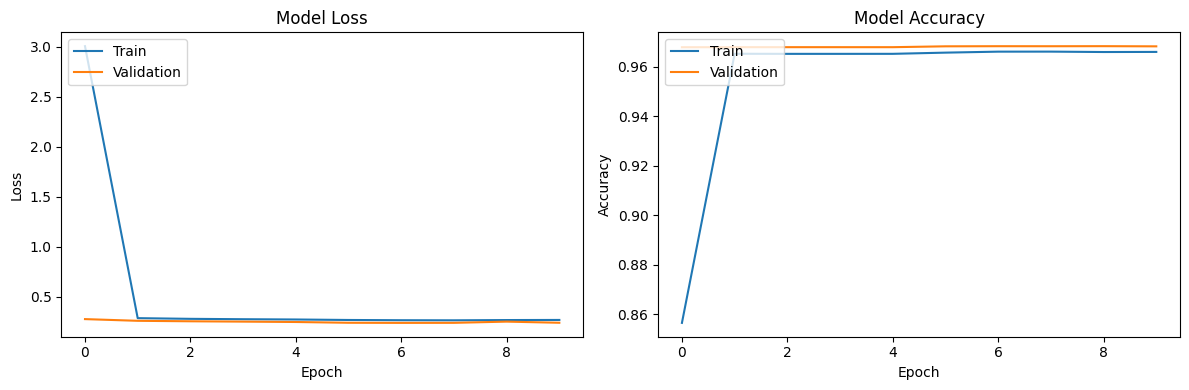

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [30]:
# Save the entire model (architecture + weights)
simple_rnn_model.save('/content/drive/My Drive/capstone/rnn_model_checkpoint.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Load the weights into the model
rnn_checkpoint_path = '/content/drive/My Drive/capstone/rnn_model_checkpoint.h5'
best_rnn_model=load_model(rnn_checkpoint_path)

In [32]:
train_loss, train_accuracy = simple_rnn_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = simple_rnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

63/63 [==============================] - 63s 1s/step - loss: 0.2405 - accuracy: 0.9682
Training Loss: 0.26403510570526123, Training Accuracy: 0.9660286903381348
Validation Loss: 0.24052298069000244, Validation Accuracy: 0.9681781530380249


In [33]:
accuracy = test_accuracy

In [34]:
# Store accuracy in a dataframe
results_df = pd.DataFrame({'Model': ['RNN'], 'Accuracy': [accuracy * 100]})
results_df

,Model,Accuracy
0,RNN,96.817815


In [35]:
# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = simple_rnn_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 244ms/step
Example 1:
Actual English:   amendment of the treaties was however limited to a review of some internal rules which was necessary and important but did not answer the fundamental question what is europe what are its common principles and therefore its objectives and limitations
Predicted English: is

Example 2:
Actual English:   the provision which is still contained in the accession agreements of spain and portugal is due to run out at the end of this year
Predicted English: 

Example 3:
Actual English:   am sure that the member states of the eu are opposed to any attempt to undermine the concepts of and interdependence of human rights
Predicted English: the

Example 4:
Actual English:   is something there are good reasons for doing because other methods of are still less appropriate from health and environmental points of view
Predicted English: the

Example 5:
Actual English:   is very difficult to tell you that one is better than

Simple LSTM model

In [36]:
# Define the model
simple_lstm_model = Sequential()
simple_lstm_model.add(LSTM(256, input_shape=(max_len, 1), return_sequences=True))
simple_lstm_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
simple_lstm_model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
simple_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 645, 256)          264192    
                                                                 
 dense_1 (Dense)             (None, 645, 19340)        4970380   
                                                                 
Total params: 5234572 (19.97 MB)
Trainable params: 5234572 (19.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Define the callbacks
lstm_checkpoint_path = '/content/drive/MyDrive/capstone/lstm_model_checkpoint.h5'
lstm_checkpoint = ModelCheckpoint(
    filepath=lstm_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model with callbacks
history = simple_lstm_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=10,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[lstm_checkpoint, early_stopping]
)

Epoch 1/10
18/63 [=======>......................] - ETA: 4:36 - loss: 7.5302 - accuracy: 0.9552

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load best LSTM model from checkpoint
best_lstm_model = load_model(lstm_checkpoint_path)
best_lstm_model.load_weights(lstm_checkpoint_path)

In [ ]:
test_loss, test_accuracy = simple_lstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

In [ ]:
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

In [ ]:
accuracy = test_accuracy

In [ ]:
# Store accuracy in a dataframe
lstm_results_df = pd.DataFrame({'Model': ['LSTM'], 'Accuracy': [accuracy * 100]})
lstm_results_df

In [ ]:
# Choose 5 random indices from test set
random_indices = random.sample(range(len(test_german_padded)), 5)

# Select the random samples from X_test and y_test
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]

# Predict using the RNN model
y_sample_pred = simple_lstm_model.predict(X_sample)

# Decode sequences from indices to words using tokenizer
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence

# Decode actual and predicted sequences
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

# Print actual and predicted sequences
for i in range(len(random_indices)):
    print(f"Example {i + 1}:")
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

In [ ]:
# Combine RNN and LSTM results
combined_results_df = pd.concat([results_df, lstm_results_df], ignore_index=True)
combined_results_df